In [1]:
import torch
import torch.nn as nn

import torch_geometric
from torch_geometric.nn import GCNConv, SoftmaxAggregation
from torch_geometric.datasets import QM9
import torch_geometric.nn as gnn
import torch.nn.functional as F

import GCL.augmentors as A

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression, LinearRegression

import numpy as np
import matplotlib.pyplot as plt

import copy
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
qm9_index = {0: 'Dipole moment',
1: 'Isotropic polarizability',
2: 'Highest occupied molecular orbital energy',
3: 'Lowest unoccupied molecular orbital energy',
4: 'Gap between previous 2',
5: 'Electronic spatial extent',
6: 'Zero point vibrational energy',
7: 'Internal energy at 0K',
8: 'Internal energy at 298.15K',
9: 'Enthalpy at 298.15K',
10: 'Free energy at 298.15K',
11: 'Heat capavity at 298.15K',
12: 'Atomization energy at 0K',
13: 'Atomization energy at 298.15K',
14: 'Atomization enthalpy at 298.15K',
15: 'Atomization free energy at 298.15K',
16: 'Rotational constant A',
17: 'Rotational constant B',
18: 'Rotational constant C',}

In [3]:
parameters = {}

# Augmentation selection
augs = [#A.RWSampling(num_seeds=1000, walk_length=10),
        #A.EdgeAttrMasking(pf=0.1),
        #A.MarkovDiffusion(),
        A.NodeDropping(pn=0.1),
        A.NodeShuffling(),
        #A.EdgeAdding(pe=0.1),
        A.FeatureMasking(pf=0.1),
        A.FeatureDropout(pf=0.1),
        A.EdgeRemoving(pe=0.1)]

augmentation = A.RandomChoice(augs, num_choices=2)
val_aug = A.RandomChoice([], num_choices = 0)

parameters['augmentation'] = augmentation

# Hyperparameters
parameters['n_epochs'] = 50
parameters['learning_rate'] = 3e-4
parameters['batch_size'] = 1024

# Supervised criterion
metrics = [mean_squared_error, mean_absolute_error, r2_score]



In [4]:
whole_dataset = QM9(root = 'data/')
n = whole_dataset.len()
tr_n = 0.5  # Number of QM9 to use as training data

all_inds = range(n)
tr_inds, val_inds = train_test_split(all_inds, train_size = tr_n)
train_set = torch.utils.data.Subset(whole_dataset, tr_inds)
val_set = torch.utils.data.Subset(whole_dataset, val_inds)

train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = parameters['batch_size'],
                                                shuffle = True, num_workers = 2,)

big_train_loader = torch_geometric.loader.DataLoader(train_set, batch_size = 4096*2,
                                                shuffle = True, num_workers = 2,)

val_loader = torch_geometric.loader.DataLoader(val_set, batch_size=4096*2, # I am using this to get a random subset of the val set
                                            shuffle=True, num_workers=2,)

In [5]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.rep_dim = 128
        self.emb_dim = 256
        
        # Data under graph
        self.conv1 = GCNConv(whole_dataset.num_node_features, self.rep_dim // 2)
        self.conv1.aggr = SoftmaxAggregation(learn=True)
        self.bn1 = nn.BatchNorm1d(self.rep_dim // 2)
        self.a1 = nn.LeakyReLU(0.02)
        
        self.conv2 = GCNConv(self.rep_dim // 2, self.rep_dim) # To Rep Space
        self.conv2.aggr = SoftmaxAggregation(learn=True)
        self.bn2 = nn.BatchNorm1d(self.rep_dim)
        
        # Projection to representation
        self.mpool1 = gnn.global_mean_pool
        #self.fc1 = nn.Linear(self.rep_dim, self.rep_dim)
        
        # Graph 2
        self.conv3 = GCNConv(self.rep_dim, self.rep_dim * 2) # To Emb Space
        self.bn3 = nn.BatchNorm1d(self.rep_dim * 2)
        
        # Projection to embedding
        #self.mpool2 = gnn.global_mean_pool
        #self.fc2 = nn.Linear(self.emb_dim, self.emb_dim) # Linear to rep?
        
    def forward(self, data, binds):
        x = data[0].float().to(device)
        edge_index = data[1].to(device)
        
        x = self.conv1(x, edge_index)
        x = self.a1(self.bn1(x))
        x = F.dropout(x, training=self.training)
        
        x = self.bn2(self.conv2(x, edge_index))
        
        x_rep = self.mpool1(x, binds)
        
        x_emb = self.conv3(x, edge_index)
        return x_rep, x_emb


In [8]:
def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

def VicRegLoss(x, y):
    # https://github.com/facebookresearch/vicreg/blob/4e12602fd495af83efd1631fbe82523e6db092e0/main_vicreg.py#L184
    # x, y are output of projector(backbone(x and y))
    
    # These are the default params used in natural image vicreg
    sim_coeff = 25
    std_coeff = 25
    cov_coeff = 1
    
    
    repr_loss = F.mse_loss(x, y)

    x = x - x.mean(dim=0)
    y = y - y.mean(dim=0)

    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)
    std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

    cov_x = (x.T @ x) / (parameters['batch_size'] - 1)
    cov_y = (y.T @ y) / (parameters['batch_size'] - 1)
    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(
        x.shape[1]
    ) + off_diagonal(cov_y).pow_(2).sum().div(x.shape[1])
    
    # self.num_features -> rep_dim?
    loss = (
        sim_coeff * repr_loss
        + std_coeff * std_loss
        + cov_coeff * cov_loss
    )
    return loss


def train(parameters):
    
    device = 'cuda'

    model = GCN().to(device)
    n_epochs = parameters['n_epochs']
    aug = parameters['augmentation']
    
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'], weight_decay=5e-4)

    tr_losses = []
    val_losses = []

    for epoch in range(0,n_epochs+1):
        epoch_losses = []
        for batch in train_loader:
            #print('training batch')
            optimizer.zero_grad()

            batch_inds = batch.batch.to(device)

            # batch of graphs has edge attribs, node attribs - (n_nodes, n_features+1) -> concat (n_nodes, attrib1)
            batch.x = batch.x.float()#.to(device)
            
            #print('batch.x.shape', batch.x.shape)

            # Barlow - get 2 random views of batch
            b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
            b2 = aug(batch.x, batch.edge_index, batch.edge_attr)

            # Embed each batch (ignoring representations)
            r1, e1 = model(b1, batch_inds)
            r2, e2 = model(b2, batch_inds)
            
            #print('calcing loss')

            loss = VicRegLoss(e1, e2)
            #print('backward loss')
            loss.backward()
            optimizer.step()
            #print('succesful backward')

            epoch_losses.append(loss.data.item())

        #print('epoch train loss', sum(epoch_losses) / len(epoch_losses))
        tr_losses.append(sum(epoch_losses) / len(epoch_losses))
        
        # VicReg Validation Loss
        if True:
            val_loss = []
            for batch in val_loader:
                with torch.no_grad():
                    #print('calcuing validation')
                    # VicReg validation loss
                    b1 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    b2 = aug(batch.x, batch.edge_index, batch.edge_attr)
                    r1, e1 = model(b1, batch.batch.to(device))
                    r2, e2 = model(b2, batch.batch.to(device))

                    val_loss.append(VicRegLoss(e1, e2).item())

            val_losses.append(torch.mean(torch.FloatTensor(val_loss)))
            #print('successful validation')
    
    return model, tr_losses, val_losses

def test(model, big_train_loader, val_loader, parameters):
    print('entering test, ')
    # Downstream supervised loss      
    scores = []
    for batch in big_train_loader: # take entire train set
        with torch.no_grad():
            # Embed training set under model
            rep_tr, _ = model(val_aug(batch.x, batch.edge_index, batch.edge_attr), batch.batch.to(device))

            for i, val_batch in enumerate(big_val_loader):
                #print('doing a batch')
                # Embed validation set under model
                rep_val, _ = model(val_aug(val_batch.x, val_batch.edge_index, val_batch.edge_attr), val_batch.batch.to(device))

                # For each task in QM9
                for tar_ind in range(batch.y.shape[1]):
                    # Fit a model on model representation of train set
                    lm = LinearRegression().fit(rep_tr.cpu(), batch.y[:,tar_ind])
                    # Test the model on model repersentation of val set
                    tar_yhat = lm.predict(rep_val.cpu())
                    mse_met = mean_squared_error(val_batch.y[:,tar_ind], tar_yhat).item()
                    r2_met = r2_score(val_batch.y[:,tar_ind], tar_yhat)
                    scores.append(mse_met)
                    
                if i==0:
                    break # Only want first batch, please
                    
            #print('left the first test one')
                    
    return scores

def transfer(model, val_loader, parameters):
    # Transfer a model trained under the supervised paradigm    
    # Need to get training set embeddings:
    train_batch = next(iter(big_train_loader))
    with torch.no_grad():
        tr_emb, _ = model([train_batch.x.float().to(device), train_batch.edge_index, train_batch.edge_attr], train_batch.batch.to(device))
        #print('train embeddings', tr_emb.shape)
        tr_emb = tr_emb.cpu()
    
    val_batch = next(iter(val_loader))

    batch_inds = val_batch.batch.to(device)
    val_batch.x = val_batch.x.float()#.to(device)


    with torch.no_grad():
        val_emb, _ = model([val_batch.x, val_batch.edge_index, val_batch.edge_attr], batch_inds)
        #print('batch embeding:', val_emb.shape)
        val_emb = val_emb.cpu()

    scoremat = torch.zeros((len(qm9_index.keys()), len(metrics)))
    for task in qm9_index.keys():
        linear_classifier = LinearRegression().fit(tr_emb, train_batch.y[:,task])
        yhat = linear_classifier.predict(val_emb)
        for meti, metric in enumerate(metrics):
            met = metric(yhat, val_batch.y[:,task])
            scoremat[task, meti] = met.astype(np.float64)
            
    print('Returning transfer scores', scoremat.shape)
    return scoremat

[1047.4661450386047, 261.67248725891113, 168.20297694206238, 124.17068874835968, 84.04603266716003, 71.52993816137314, 62.56000077724457, 55.572335839271545, 50.35296595096588, 43.80746078491211, 39.135438054800034, 36.693260967731476, 34.785380363464355, 35.1208752989769, 32.89046770334244, 34.17290514707565, 32.309844464063644, 31.63206759095192, 29.111990064382553, 30.006967782974243, 28.97005107998848, 27.687619537115097, 26.50340384244919, 27.88970485329628, 26.683565109968185, 27.329157322645187, 26.61985483765602, 25.659015834331512, 25.526419162750244, 25.327769815921783, 25.71259731054306, 24.967057555913925, 25.247737228870392, 24.850244998931885, 25.140160590410233, 24.828017204999924, 24.424856781959534, 24.63853731751442, 24.593614846467972, 24.12583965063095, 24.00447306036949, 24.333480715751648, 24.45249170064926, 24.01421132683754, 23.870870918035507, 23.96859374642372, 23.71226167678833, 23.762040495872498, 23.966142177581787, 23.801112294197083, 23.863458424806595] [

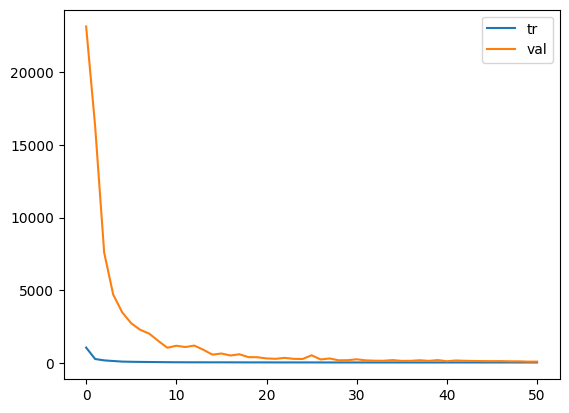

Returning transfer scores torch.Size([19, 3])


C:\Users\Alex\anaconda3\envs\rdk\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


[1198.922950744629, 368.64890336990356, 200.6894030570984, 135.75519132614136, 104.88611221313477, 84.68567627668381, 68.07650834321976, 60.93907344341278, 53.81665259599686, 59.27242052555084, 43.355392932891846, 41.665782034397125, 38.92837220430374, 37.74789237976074, 34.69409644603729, 34.071220844984055, 33.284595757722855, 31.7706161737442, 30.58029067516327, 31.090750068426132, 30.411390364170074, 28.850472778081894, 28.019061118364334, 27.30133345723152, 27.77908444404602, 27.632499784231186, 27.102053433656693, 26.958574682474136, 26.762100875377655, 25.734591156244278, 25.976823329925537, 25.979476273059845, 25.458306819200516, 25.634848952293396, 25.367024689912796, 24.883086144924164, 25.173702746629715, 24.964711874723434, 24.7885984480381, 24.997698038816452, 24.771586537361145, 24.35151919722557, 24.533971339464188, 24.297931492328644, 24.1475787460804, 24.24710413813591, 24.109458208084106, 24.12493261694908, 23.937622368335724, 23.8346286714077, 24.086688190698624] [te

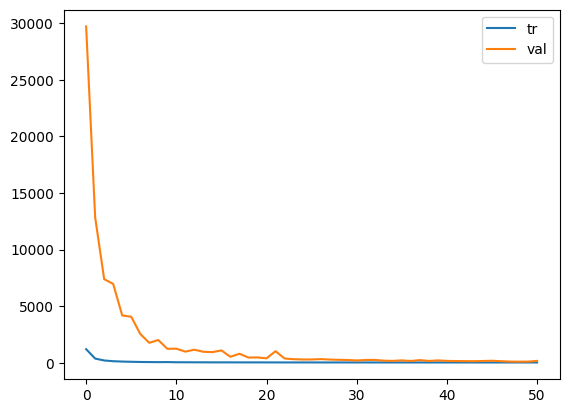

Returning transfer scores torch.Size([19, 3])


In [9]:
n_trials = 3
for i in range(1,n_trials):
    model, tr_loss, val_loss = train(parameters)
    
    print(tr_loss, val_loss)
    plt.plot(tr_loss, label = 'tr')
    plt.plot(val_loss, label = 'val')
    plt.legend(loc = 'best')
    plt.show()
    
    scores = transfer(model, val_loader, parameters)
    torch.save(scores, f'heatmap_results/vicreg_{i}.pt')

In [ ]:

plt.plot(tr_loss, label = 'tr')
plt.plot(val_loss, label = 'val')
plt.legend(loc = 'best')
plt.show()



In [ ]:

print(scores)
print(scores.shape)

In [ ]:
for met, row in zip(metrics, scores.T):
    #print(met, row)
    for i, item in enumerate(row):
        print(met, qm9_index[i], item)
        
torch.save(scores, 'vicreg_score_demo.pt')